# **Project - Recommendation Systems: Movie Recommendation System**

---------------
## **Context**
---------------

Online streaming platforms like **Netflix** have plenty of movies in their repository and if we can build a **Recommendation System** to recommend **relevant movies** to users, based on their **historical interactions**, this would **improve customer satisfaction** and hence, it will also improve the revenue of the platform.

-----------------
## **Objective**
-----------------

In this project we will be building various recommendation systems: 
- Knowledge/Rank based recommendation system
- Similarity-Based Collaborative filtering
- Matrix Factorization Based Collaborative Filtering

we are going to use the **ratings** dataset. 

-----------------
## **Dataset**
-----------------

The **ratings** dataset contains the following attributes: 
- userId
- movieId
- rating
- timestamp

**Installing surprise library**

In [1]:
# Installing surprise library, only do it for first time
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [2]:
# Used to ignore the warning given as output of the code
import warnings                                 
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np                              
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt     

# Slightly advanced library for data visualization            
import seaborn as sns                           

# A dictionary output that does not raise a key error
from collections import defaultdict             

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing cross validation
from surprise.model_selection import KFold

### **Loading the data**

In [3]:
# Import the dataset
rating = pd.read_csv('ratings.csv')
#rating = pd.read_csv('/content/drive/MyDrive/ratings.csv') # Uncomment this line code  and comment above line of code if you are using google colab.

Let's check the **info** of the data

In [4]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- There are **1,00,004 observations** and **4 columns** in the data
- All the columns are of **numeric data type**
- The data type of the timestamp column is int64 which is not correct. We can convert this to DateTime format but **we don't need timestamp for our analysis**. Hence, **we can drop this column**

In [5]:
# Dropping timestamp column
rating = rating.drop(['timestamp'], axis=1)

## **Exploring the dataset**

Let's explore the dataset and answer some basic data-related questions:

In [6]:
# Printing the top 5 rows of the dataset Hint: use .head()

rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [7]:
rating.describe()

,userId,movieId,rating
count,100004.000000,100004.000000,100004.000000
mean,347.011310,12548.664363,3.543608
std,195.163838,26369.198969,1.058064
min,1.000000,1.000000,0.500000
25%,182.000000,1028.000000,3.000000
50%,367.000000,2406.500000,4.000000
75%,520.000000,5418.000000,4.000000
max,671.000000,163949.000000,5.000000


### **Describe the distribution of ratings.**



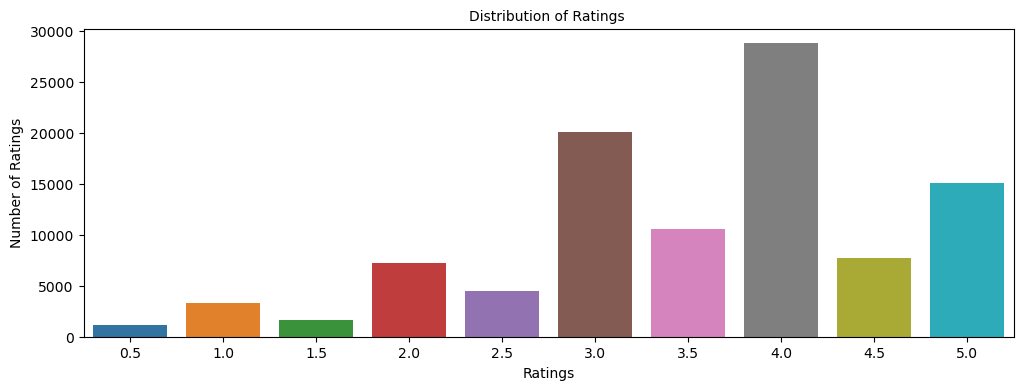

In [8]:
plt.figure(figsize = (12, 4))

sns.countplot(x="rating", data=rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

**Observations**

1. The ratings are not uniformly distributed but rather slightly left skewed.
2. Rating '4' has the highest count of ratings (>25000), Rating '3' is second with (>20000) and Rating '5' third with (>15000)
3. Lower ratings, such as 0.5, and perfect ratings (5.0) have fewer occurrences in the dataset. This indicates that users tend to give moderate to high ratings more frequently than extreme low or high ratings.
4. The ratings are biased towards 3 to 4.

In [9]:
# Finding number of unique users
rating['userId'].nunique()

671

**Observations**

1. There are 671 unique users

In [10]:
# Finding number of unique movies

rating['movieId'].nunique()

9066

**Observations**

1. There are 9066 unique movies

In [11]:
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [12]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

In [13]:
# Group the dataset by user and movie, then count the interactions
interaction_counts = rating.groupby(['userId', 'movieId']).size().reset_index(name='interactions')

# Filter the interactions where the count is greater than 1
multiple_interactions = interaction_counts[interaction_counts['interactions'] > 1]

# Display the result
if multiple_interactions.empty:
    print("No movie has been interacted with more than once by the same user.")
else:
    print("There are movies that have been interacted with more than once by the same user.")
    print(multiple_interactions)


No movie has been interacted with more than once by the same user.


**Observations**

1. No movie has been interacted with more than once by the same user as the sum is equal to the total number of observations

### **Most interacted movie in the dataset**

In [14]:
rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

**Observations**

1. The movie with Id: 356 has been interacted by most users which is 341 times.
2. But still, there is a possibility of 670-341 = 329 more interactions for the movie with ID 356 as we have 670 unique users in our datasets. For those 329 remaining users, we can build a recommendation system to predict who is most likely to interact with the item.
3. Also, out of these 329 interactions, we need to consider the distribution of ratings as well.

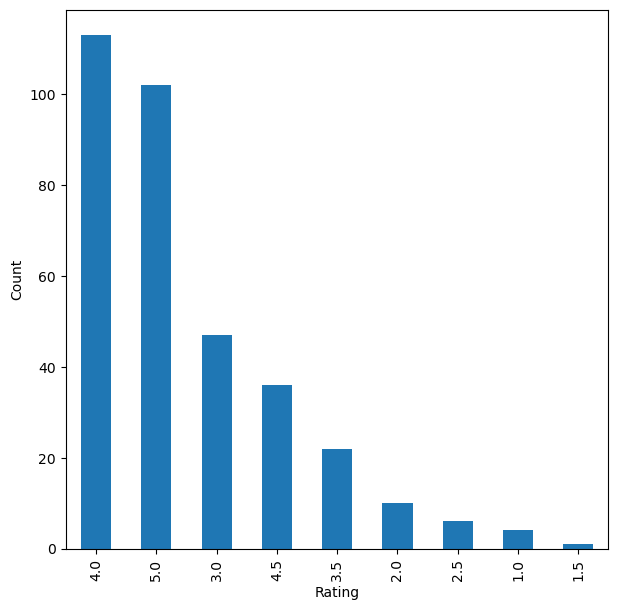

In [15]:
# Plotting distributions of ratings for 341 interactions with movieid 356 
plt.figure(figsize=(7,7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

**Observations**

1. Since the movie with ID 356 has the most interactions in the dataset, it is a popular movie among users. There are a considerable number of high ratings (e.g., 4 and 5) in the distribution.

2. The movie is generally well-received by users who interacted with it, as a positively skewed distribution suggests that there are more high ratings than low ratings.

3. The most frequent rating values are in the range of 3.5 to 5 stars. 

4. The tail of the distribution extends more towards the lower ratings (e.g., 1 - 2), but there are a fewer occurrences of these ratings compared to higher ratings.

In [16]:
rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

**Observations**

1. The user with userId 547 has interacted with the most movies in the dataset, rating a total of 2391 movies. This user is an active participant and provides valuable information for understanding user preferences.

2. There is a possibility of 6675 more interactions for this user (9066 unique movies - 2391 rated movies). A recommendation system can be built to predict which of the remaining 6675 movies the user is most likely to watch based on their past interactions and preferences.

### **Distribution of the user-movie interactions in the dataset**

In [17]:
# Finding user-movie interactions distribution
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

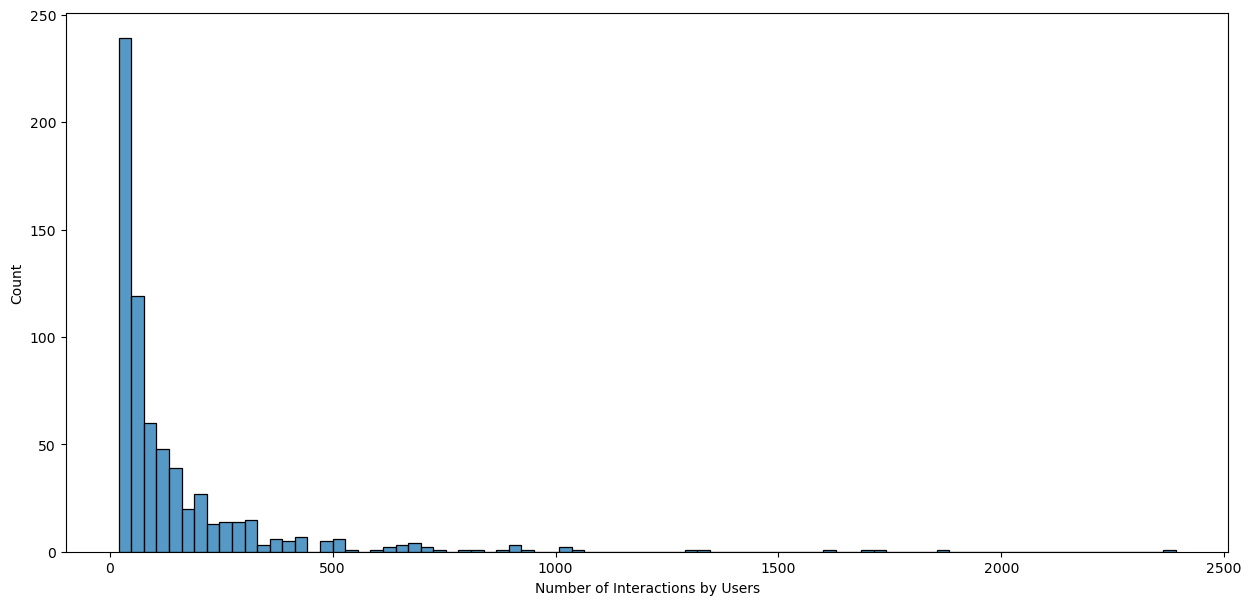

In [18]:
# Plotting user-movie interactions distribution

plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

**Observations**

1. The distribution is positively skewed, with a majority of users having a lower number of interactions. This indicates that most users have rated a relatively small number of movies compared to the total number of available movies.

2. There is a long tail in the distribution, representing a smaller number of highly active users with a significantly higher number of interactions. These users can be considered as "power users" who contribute valuable data for understanding user preferences and movie reception.

3. The peak of the distribution represents the most common number of movie interactions per user, which is low. This suggests that many users have interacted with only a few movies.

4. There are some outliers, representing users with an exceptionally high number of interactions (>2000). 

#### As we have now explored the data, let's start building Recommendation systems

## **Create Rank-Based Recommendation System**

### **Model 1: Rank-Based Recommendation System**

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend movies to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend movies to the new user.

To build the rank-based recommendation system, we take **average** of all the ratings provided to each movie and then rank them based on their average rating.

In [19]:
# Calculating average ratings
average_rating = rating.groupby('movieId').mean()['rating']

# Calculating the count of ratings
count_rating = rating.groupby('movieId').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [20]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


Now, let's create a function to find the **top n movies** for a recommendation based on the average ratings of movies. We can also add a **threshold for a minimum number of interactions** for a movie to be considered for recommendation. 

In [21]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] >= min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get movies to recommend

#### **Recommending top 5 movies with 50 minimum interactions based on popularity**

In [22]:
list(top_n_movies(final_rating, 5, 50))

[858, 318, 969, 913, 1221]

#### **Recommending top 5 movies with 100 minimum interactions based on popularity**

In [23]:
list(top_n_movies(final_rating, 5, 100))

[858, 318, 1221, 50, 527]

#### **Recommending top 5 movies with 200 minimum interactions based on popularity**

In [24]:
list(top_n_movies(final_rating, 5, 200))

[858, 318, 50, 527, 608]

Now that we have seen **how to apply the Rank-Based Recommendation System**, let's apply the **Collaborative Filtering Based Recommendation Systems**.

## **Model 2: User based Collaborative Filtering Recommendation System**

![collaborative_filtering.PNG](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/collaborative_filtering.PNG)

In the above **interactions matrix**, out of users B and C, which user is most likely to interact with the movie, "The Terminal"?

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

**Types of Collaborative Filtering**

- Similarity/Neighborhood based

 * User-User Similarity Based  
 * Item-Item similarity based

- Model based

#### **Building Similarity/Neighborhood based Collaborative Filtering**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/cosine.PNG)

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`**. Finally splitting the data into train and test set.

#### **Making the dataset into surprise dataset and splitting it into train and test set**

In [25]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#### **Build the first baseline similarity based recommendation system using cosine similarity and KNN**

In [26]:
# Defining Nearest neighbour algorithm
algo_knn_user = KNNBasic(sim_options={'name': 'cosine',
               'user_based': True},verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_user.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9925


0.9924509041520163

### **RMSE for baseline user based collaborative filtering recommendation system**

**Observations**

1. As we can see from above, these baseline model has RMSE=0.9925 on test set. This means that, on average, the predicted ratings are off by 0.9925 from the actual ratings in the test se

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [27]:
algo_knn_user.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

**Observations**

1. The actual rating given by the user for item 10 is 4 (r_ui=4.0), and the estimated rating predicted by the algorithm is 3.62 (est=3.6244912065910952).

2. The actual_k parameter in the details dictionary specifies the number of neighbors used by the algorithm to make the prediction, which is 40 in this case. The was_impossible parameter is False, which means the prediction was possible and there were no errors.

3. Overall, this prediction suggests that the user with ID 4 is likely to rate item 10 with a rating of around 3.62.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [28]:
algo_knn_user.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

**Observations**

1. In this case, the user has not rated item 3 yet, so the actual rating (r_ui) is None. The estimated rating predicted by the algorithm for this user and item is 3.20 (est=3.202703552548654).

2. The actual_k parameter in the details dictionary specifies the number of neighbors used by the algorithm to make the prediction, which is 40 in this case. The was_impossible parameter is False, which means the prediction was possible and there were no errors.

3. Overall, this prediction suggests that the user with ID 4 is likely to rate item 3 with a rating of around 3.20, based on the ratings of similar users who have rated this item.

### **Improving user-user similarity based recommendation system by tuning its hyper-parameters**

Below we will be tuning hyper-parmeters for the `KNNBasic` algorithms. Let's try to understand different hyperparameters of KNNBasic algorithm - 

- **k** (int) – The (max) number of neighbors to take into account for aggregation (see this note). Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - pearson
    - pearson baseline
    
For more details please refer the official documentation https://surprise.readthedocs.io/en/stable/knn_inspired.html

### **Performing hyperparameter tuning for the baseline user based collaborative filtering recommendation system and find the RMSE for tuned user based collaborative filtering recommendation system**

In [29]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}}

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9648250383498848
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [30]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.961336,0.969053,0.964086,0.964825,0.003194,1,0.740432,0.743463,0.742547,0.742147,0.001269,1,0.035838,0.003811,1.445596,0.018434,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.990369,0.996982,0.993002,0.993451,0.002719,14,0.766863,0.769093,0.768552,0.768169,0.000950,12,0.063053,0.013039,1.515597,0.019200,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.966033,0.972133,0.967961,0.968709,0.002546,3,0.743517,0.746132,0.745600,0.745083,0.001129,3,0.048371,0.025716,1.507318,0.020957,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.993273,0.998488,0.995321,0.995694,0.002145,15,0.768691,0.770536,0.770362,0.769863,0.000832,15,0.074603,0.010675,1.413666,0.012167,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.971273,0.977640,0.974108,0.974340,0.002604,7,0.748264,0.750832,0.750590,0.749896,0.001158,6,0.056240,0.013033,1.415201,0.012908,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.



In [31]:
# Using the optimal similarity measure for user-user based collaborative filtering
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options={'name': 'cosine',
               'user_based': True}, k=20, min_k=3,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9908


0.9907563598665419

**Observations**

1. The RMSE for the optimized user-user collaborative filtering model is 0.9908, which is slightly better than the baseline user-user collaborative filtering model (RMSE = 0.9925)

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [32]:
similarity_algo_optimized_user.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.57   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.574853251279223, details={'actual_k': 20, 'was_impossible': False})

**Observations**

1. The optimized user-user collaborative filtering model predicts that the user with ID 4 will rate movie ID 10 with a predicted rating of 3.57 as compared to the baseline model which is 3.62, given that the actual rating provided by the user for this movie is 4

Below we are predicting rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model as shown below - 

In [33]:
similarity_algo_optimized_user.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.25   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.2547587330037486, details={'actual_k': 20, 'was_impossible': False})

**Observations**

1. The optimized user-user collaborative filtering model predicts that the user with ID 4 will rate movie ID 3 with a predicted rating of 3.25 as compared to the baseline model of 3.20. However, the user has not provided any actual rating for this movie.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=4` based on the `msd` distance metric

In [34]:
similarity_algo_optimized_user.get_neighbors(4, k=5)

[357, 220, 590, 491, 647]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are - 

- data: a rating dataset
- user_id: an user id against which we want the recommendations
- top_n: the number of movies we want to recommend
- algo: the algorithm we want to use to predict the ratings

In [35]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # Predicting the ratings for those non interacted movie ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [36]:
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_user)

In [37]:
recommendations

[(309, 5),
 (3038, 4.999999999999999),
 (6273, 4.839859025263867),
 (98491, 4.832340578646058),
 (116, 4.753206589295344)]

## **Model 3: Item based Collaborative Filtering Recommendation System**

In [38]:
# Definfing similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0032


1.003221450633729

### **RMSE for baseline item based collaborative filtering recommendation system**

**Observations**

1. The item-item based collaborative filtering approach had a higher RMSE of 1.0032 as compared to the user-user based collaborative filtering approach that had an RMSE of 0.9925 for the baseline model. This suggests that the user-user based collaborative filtering approach performed slightly better in predicting the ratings.

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [39]:
algo_knn_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.37   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.373794871885004, details={'actual_k': 40, 'was_impossible': False})

**Observations**

1. For user 4 and item 10, the predicted rating is 4.37. The actual number of neighbors considered for prediction (actual_k) is 40, and the prediction was not considered impossible.

Let's predict  the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [40]:
algo_knn_item.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 4.07   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

**Observations**
1. The predicted rating for user 4 on movie 3 is 4.07 using item-item collaborative filtering. 

### **Performing hyperparameter tuning for the baseline item based collaborative filtering recommendation system and find the RMSE for tuned item based collaborative filtering recommendation system**

In [41]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}}

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9406909349273437
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above**

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [42]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.953771,0.951072,0.950351,0.951731,0.001472,7,0.736367,0.734794,0.732655,0.734605,0.001521,7,10.753525,0.109808,9.046006,0.015310,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.012776,1.014584,1.014038,1.013799,0.000757,16,0.790248,0.791389,0.790150,0.790596,0.000562,16,16.660893,0.277698,8.910250,0.285031,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.953728,0.951359,0.950712,0.951933,0.001296,8,0.736484,0.734925,0.733071,0.734827,0.001395,8,8.533379,2.915597,10.061734,1.587265,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,1.012904,1.015007,1.014401,1.014104,0.000883,17,0.790430,0.791627,0.790492,0.790850,0.000550,17,16.253777,0.090644,8.862720,0.146827,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.954158,0.952101,0.951188,0.952482,0.001242,9,0.736833,0.735418,0.733233,0.735161,0.001481,9,6.587613,0.752816,10.801735,1.038442,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [43]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=40, min_k=3,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9433


0.9433184999641279

**Observations**

1. The RMSE value of the optimized item-based collaborative filtering model (0.9433) is lower than the baseline item-based collaborative filtering model (1.0032). This indicates that the optimized model is performing better in predicting the user-item ratings.

### **Predicting rating for an item with userId =4 and for movieId= 10 and movieId=3 using tuned item based collaborative filtering**

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model as shown below

In [44]:
similarity_algo_optimized_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.26   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.255054787154994, details={'actual_k': 40, 'was_impossible': False})

**Observations**

1. The baseline model predicted a rating of 4.37 for movie 10 by user 4, while the optimized model predicted a rating of 4.26 for the same item and user.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model:

In [45]:
similarity_algo_optimized_item.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.87   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.865175609312417, details={'actual_k': 40, 'was_impossible': False})

**Observations**

1. The baseline model predicted a rating of 4.07 for movie 3 by user 4, while the optimized model predicted a rating of 3.87 for the same item and user.


### **Identifying similar items to a given item (nearest neighbors)**
We can also find out the similar items to a given item or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar items to the `movieId=3` based on the `msd` distance metric

In [46]:
similarity_algo_optimized_item.get_neighbors(3, k=5)

[31, 37, 42, 48, 73]

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [47]:
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

In [48]:
recommendations

[(84, 5), (1040, 5), (2481, 5), (3078, 5), (3116, 5)]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


## **Model 4: Based Collaborative Filtering - Matrix Factorization using SVD**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

**Latent Features:** The features that are not present in the empirical data but can be inferred from the data. For example:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF3.PNG)

Now if we notice the above movies closely:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF4.PNG)

Here **Action**, **Romance**, **Suspense** and **Comedy** are latent features of the corresponding movies. Similarly, we can compute the latent features for users as shown below:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF5.PNG)



### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

First we need to convert the below movie-rating dataset:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF3.PNG)

into an user-item matrix as shown below:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF6.PNG)

We have already done this above while computing cosine similarities.

**SVD decomposes this above matrix into three separate matrices:**
- U matrix
- Sigma matrix
- V transpose matrix

#### **U-matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF7.PNG)

the above matrix is a n x k matrix, where:
- n is number of users
- k is number of latent features

#### **Sigma-matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF8.PNG)

the above matrix is a k x k matrix, where:
- k is number of latent features
- Each diagonal entry is the singular value of the original interaction matrix

#### **V-transpose matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF9.PNG)

the above matrix is a kxn matrix, where:
- k is the number of latent features
- n is the number of items

### **Build a baseline matrix factorization recommendation system**

In [49]:
# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9021


0.9021257134544953

### **RMSE for baseline SVD based collaborative filtering recommendation system**

**Observation**

1. We can see that the baseline RMSE for matrix factorization model on testset (which is 0.9021) is lower as compared to the RMSE for baseline similarity based recommendation system (which is 1.003) and it is even lesser than the RMSE for optimized similarity based recommendation system (which is 0.943). The SVD-based collaborative filtering model performs better than the baseline similarity-based and optimized similarity-based models in terms of RMSE.

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [50]:
algo_svd.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.21   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.21283156362353, details={'was_impossible': False})

**Observations**

As we can see the actual rating for this user-item pair is 4 and predicted rating is 4.21 by this matrix factorization based baseline model. It seems like we have over estimated the rating by a small margin.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [51]:
algo_svd.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.74   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.7409416208151898, details={'was_impossible': False})

**Observations**

1. We can see that estimated rating for this user-item pair is 3.74 based on this matrix factorization based baseline model.

### **Improving matrix factorization based recommendation system by tuning its hyper-parameters**

In SVD, rating is predicted as - 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

### **Performing hyperparameter tuning for the baseline SVD based collaborative filtering recommendation system and find the RMSE for tuned SVD based collaborative filtering recommendation system**

In [52]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8942049237730069
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters, as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [53]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.942651,0.946742,0.939723,0.943039,0.002879,25,0.738594,0.741086,0.734368,0.738016,0.002773,25,0.216928,0.019317,0.208683,0.011694,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.947617,0.951654,0.944031,0.947767,0.003114,26,0.744078,0.746696,0.739615,0.743463,0.002923,26,0.285698,0.016843,0.237862,0.015930,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.952709,0.956694,0.949450,0.952951,0.002962,27,0.749394,0.752340,0.745690,0.749141,0.002721,27,0.294735,0.023477,0.222528,0.021256,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.907666,0.910490,0.902995,0.907050,0.003091,11,0.703193,0.705072,0.699293,0.702519,0.002407,9,0.281181,0.023330,0.201600,0.006980,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.914614,0.917840,0.910470,0.914308,0.003017,15,0.710843,0.712949,0.707148,0.710313,0.002398,15,0.304517,0.012740,0.240604,0.007399,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [54]:
# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8952


0.8951615304687497

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [55]:
svd_algo_optimized.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.99   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.9928649307495805, details={'was_impossible': False})

**Observations**

1. If we compare the above predicted rating, we can see the baseline model predicted rating as 4.21 and the optimized model predicted the rating as 3.99 whereas the actual rating is 4.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [56]:
svd_algo_optimized.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.65   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.645696519385192, details={'was_impossible': False})

In [57]:
get_recommendations(rating, 4, 5, svd_algo_optimized)

[(1192, 4.9931075320441405),
 (926, 4.946673520440325),
 (1948, 4.945502216974197),
 (116, 4.9442319495024645),
 (3310, 4.933378936642758)]

### **Predicting ratings for already interacted movies** 

Below we are comparing the rating predictions of users for those movies which has been already watched by an user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [58]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:
        
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # Predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

Here we are comparing the predicted ratings by `similarity based recommendation` system against actual ratings for `userId=7`

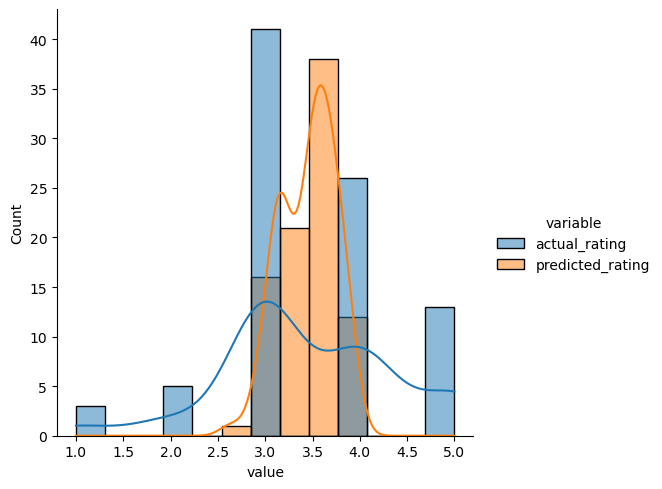

In [59]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

**Observations**

The plot shows the distribution of actual and predicted ratings for movies that have already been rated by user 7 using the optimized similarity-based recommendation system. The actual rating values are slightly right skewed and have a peak around 3.0, while the predicted ratings have a more uniform distribution with a peak around 3.5. This suggests that the optimized similarity-based model may be underestimating the actual ratings for movies that user 7 has already rated.

Below we are comparing the predicted ratings by `matrix factorization based recommendation` system against actual ratings for `userId=7`

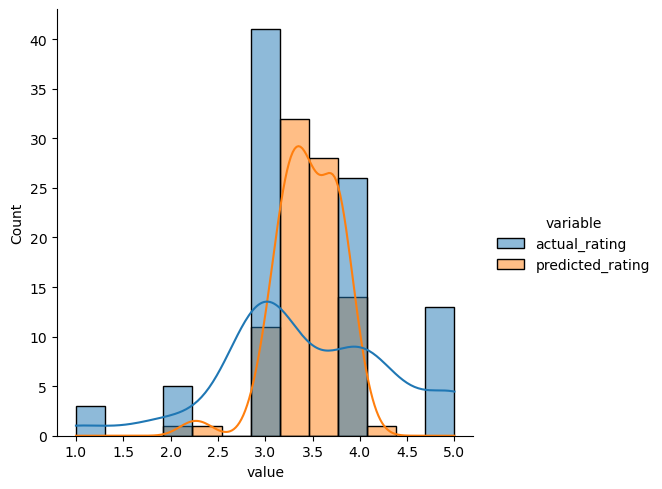

In [60]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

In [61]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

## **Precision and Recall @ k**

RMSE is not the only metric we can use here. We can also examine two fundamental measures, precision and recall. We also add a parameter k which is helpful in understanding problems with multiple rating outputs.

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. Value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  

**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**Recall** - It is the **fraction of actually relevant items that are recommended to the user** i.e. if out of 10 relevant movies, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision** - It is the **fraction of recommended items that are relevant actually** i.e. if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

### **Computing the precision and recall, for each of the 6 models, at k = 5 and 10. This is 6 x 2 = 12 numerical values**

In [62]:
# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



In [63]:
# A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [5, 10]

# Remove _______ and complete the code
# Make list of models
models = [algo_knn_user, similarity_algo_optimized_user,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.768
-----> Recall:  0.413
> k=5, model=KNNBasic
-----> Precision:  0.765
-----> Recall:  0.416
> k=5, model=KNNBasic
-----> Precision:  0.611
-----> Recall:  0.327
> k=5, model=KNNBasic
-----> Precision:  0.677
-----> Recall:  0.353
> k=5, model=SVD
-----> Precision:  0.753
-----> Recall:  0.386
> k=5, model=SVD
-----> Precision:  0.752
-----> Recall:  0.387
> k=10, model=KNNBasic
-----> Precision:  0.746
-----> Recall:  0.546
> k=10, model=KNNBasic
-----> Precision:  0.748
-----> Recall:  0.563
> k=10, model=KNNBasic
-----> Precision:  0.597
-----> Recall:  0.474
> k=10, model=KNNBasic
-----> Precision:  0.657
-----> Recall:  0.501
> k=10, model=SVD
-----> Precision:  0.739
-----> Recall:  0.521
> k=10, model=SVD
-----> Precision:  0.729
-----> Recall:  0.52


**Observations**


1. The baseline user-user and item-item based models were evaluated using RMSE metric. The RMSE for the user-user model was 0.9925 and for the item-item model was 1.0032. The RMSE for the matrix factorization based baseline model was 0.9021.We can observe that the RMSE for the matrix factorization model is lower than that of both user-user and item-item models. This indicates that the matrix factorization model provides better recommendations compared to user-user and item-item models in this case.


2. The tuned user-user and item-item models have significantly lower RMSE values than the baseline models. Specifically, the tuned user-user and item-item models have RMSE values of 0.9908 and 0.9433, respectively, while the baseline user-user and item-item models have RMSE values of 0.9925 and 1.0032, respectively.They are still outperformed by the optimized matrix factorization model with an RMSE value of 0.8952 and baseline 0.9021


3. The collaborative filtering models (user-user and item-item) make predictions based on the similarity between users or items in the rating matrix. These models use the patterns of user-item interactions in the data to identify similar users or items and make recommendations based on those similarities. On the other hand, matrix factorization is a model-based approach that uses a low-rank matrix factorization to learn latent features that explain the user-item interactions in the data. The model learns a lower-dimensional representation of the user-item interaction matrix, which is used to make predictions for unseen user-item pairs. The latent factors represent underlying features of the items and users, which are not directly observed in the data. The optimized matrix factorization model performs the best among all models, with the lowest RMSE value of 0.8951. The tuned user-user and item-item models perform similarly well, with RMSE values of 0.9908 and 0.9433, respectively. The baseline user-user and item-item models perform worse than the tuned models, with RMSE values of 0.9925 and 1.0032, respectively. In terms of precision-recall, the matrix factorization model outperforms the collaborative filtering models, achieving higher precision and recall values. The collaborative filtering models have similar precision-recall performance, with the item-item model having slightly higher precision and the user-user model having slightly higher recall.


4. The optimized matrix factorization model improves upon the baseline matrix factorization model. The optimized model has an RMSE of 0.8952, while the baseline model has an RMSE of 0.9021. This improvement is due to the hyperparameter tuning process, which allowed for finding the best values of the hyperparameters that minimize the RMSE on the test set. Additionally, the optimized matrix factorization model outperforms the collaborative filtering models, which have higher RMSE values. This could be because matrix factorization is able to capture more complex patterns in the data, such as non-linear relationships between users and items, which may not be captured by simpler collaborative filtering models.

### **Conclusions**

In this case study, we saw three different ways of building recommendation systems: 
- rank-based using averages
- similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering

We also understood advantages/disadvantages of these recommendation systems and when to use which kind of recommendation systems. Once we build these recommendation systems, we can use **A/B Testing** to measure the effectiveness of these systems.